In [1]:
%load_ext autoreload
%autoreload 2
import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import casadi as cas

##### For viewing the videos in Jupyter Notebook
import io
import base64
from IPython.display import HTML

# from ..</src> import car_plotting
# from .import src.car_plotting
PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)
import src.MPC_Casadi as mpc
import src.car_plotting as cplot

%matplotlib inline

# Vehicle Dynamics $\frac{d}{dt} \vec{x} = f(\vec{x}, \vec{u})$

#  States

$\vec{x}$ = $[x, y, \phi, \delta, V, s]^T$

$\vec{u}$ = $[\delta^u, v^u]^T$

# Discrete (integrated) dynamics $\vec{x}_{t+1} = F(\vec{x}_{t}, \vec{u}_{t})$

In [2]:
T = 10 #numbr of time horizons
dt = 0.1
N = int(T/dt) #Number of control intervals

# Problem Definition
### Parameterization of Desired Trajectory ($\vec{x}_d = f_d(s)$)

In [3]:
s = cas.MX.sym('s')
xd = s
yd = 0
phid = 0
des_traj = cas.vertcat(xd, yd, phid)
fd = cas.Function('fd',[s],[des_traj],['s'],['des_traj'])

In [4]:
#Globally true information
min_dist = 2 * (2 * .5**2)**.5

# initial_speed = 6.7 
initial_speed = 20 * 0.447 # m/s

# Initial Conditions
x0 = np.array([2*min_dist, 1.2*min_dist, 0, 0, initial_speed, 0]).T
x0_2 = np.array([2*min_dist, 0, .0, 0, initial_speed, 0]).T
x0_amb = np.array([0, 0.0, 0, 0, 1.1 * initial_speed , 0]).T

In [5]:
LANE_WIDTH = min_dist
xd2 = s
yd2 = LANE_WIDTH
phid = 0
des_traj2 = cas.vertcat(xd2, yd2, phid)
fd2 = cas.Function('fd',[s],[des_traj2],['s'],['des_traj2'])

## Warm Start

### Solve it centrally just to warm start the solution

In [6]:
x1_MPC = mpc.MPC(dt)
x2_MPC = mpc.MPC(dt)
amb_MPC = mpc.MPC(dt)

x1_MPC.k_s = -1.0
x2_MPC.k_s = -1.0

x1_MPC.theta_iamb = np.pi/4
x2_MPC.theta_iamb = np.pi/4


amb_MPC.theta_iamb = 0.0


# amb_MPC.k_u_v = 0.10
# amb_MPC.k_u_change = 1.0
amb_MPC.k_s = -1.0
amb_MPC.max_v = 40 * 0.447 # m/s
amb_MPC.max_X_dev = 5.0


x2_MPC.fd = fd
amb_MPC.fd = fd
x1_MPC.fd = fd2


x1_MPC.min_y = -1.1 * LANE_WIDTH
x2_MPC.min_y = -1.1 * LANE_WIDTH
amb_MPC.min_y = -1.1 * LANE_WIDTH

In [9]:
opt =  mpc.OptimizationMPC(x1_MPC, x2_MPC,amb_MPC)
opt.generate_optimization(N, min_dist, fd, T, x0, x0_2, x0_amb, 2)
opt.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 132.40ms (259.60us) 131.92ms (258.67us)       510
       nlp_g  | 660.08ms (  1.29ms) 655.10ms (  1.28ms)       510
    nlp_grad  |   3.79ms (  3.79ms)   3.77ms (  3.77ms)         1
  nlp_grad_f  | 359.05ms (782.24us) 356.86ms (777.48us)       459
  nlp_hess_l  |  11.33 s ( 22.93ms)  11.25 s ( 22.76ms)       494
   nlp_jac_g  |   5.32 s ( 10.68ms)   5.28 s ( 10.60ms)       498
       total  |  26.75 s ( 26.75 s)  26.55 s ( 26.55 s)         1


In [10]:
x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = opt.get_solution()

In [11]:
optional_suffix = "_central"
subdir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + optional_suffix
folder = "results/" + subdir_name + "/"
os.makedirs(folder)
os.makedirs(folder+"imgs/")
print(folder)

results/20200218-162110_central/


In [12]:
opt.save_state(folder,x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)

'results/20200218-162110_central/'

In [13]:
cplot.plot_cars(x1, x2, xamb, folder,x1_des, x2_des, xamb_des)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [14]:
CIRCLES = False
if CIRCLES:
    vid_fname = folder + subdir_name + 'circle_central.mp4'
else:
    vid_fname = folder + subdir_name + 'car_central.mp4'   
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

Saving video to: results/20200218-162110_central/20200218-162110_centralcar_central.mp4


In [15]:
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


## Decentralized:  IBR to Converge

In [16]:
## Initialize values from the centralized version
x1_current, u1_current, x1_desired_current = x1, u1, x1_des
x2_current, u2_current, x2_desired_current = x2, u2, x2_des
xamb_current, uamb_current, xamb_desired_current = xamb, uamb, xamb_des

In [18]:
br1 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC)
br1.generate_optimization(N, min_dist, fd, T, x0, x0_2, x0_amb, 2)
br1.solve(u2, uamb)
x1r1, u1r1, x1_desr1, *_, = br1.get_solution()
x1_current, u1_current, x1_desired_current = x1r1, u1r1, x1_desr1

cplot.plot_cars(x1_current, x2_current, xamb_current, folder)
CIRCLES = False
if CIRCLES:
    vid_fname = folder + subdir_name + 'circle1.mp4'
else:
    vid_fname = folder + subdir_name + 'car1.mp4'    
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  74.75ms (371.87us)  74.78ms (372.02us)       201
       nlp_g  | 304.34ms (  1.51ms) 303.66ms (  1.51ms)       201
    nlp_grad  |   4.62ms (  4.62ms)   4.61ms (  4.61ms)         1
  nlp_grad_f  | 116.02ms (648.15us) 115.99ms (647.97us)       179
  nlp_hess_l  |   3.41 s ( 17.31ms)   3.40 s ( 17.25ms)       197
   nlp_jac_g  |   1.79 s (  8.91ms)   1.78 s (  8.88ms)       201
       total  |   7.94 s (  7.94 s)   7.91 s (  7.91 s)         1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving video to: results/20200218-162110_central/20200218-162110_centralcar1.mp4


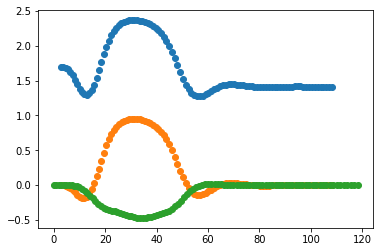

In [23]:
plt.plot(x1_current[0,:],x1_current[1,:],'o')
plt.plot(x2_current[0,:],x2_current[1,:],'o')
plt.plot(xamb_current[0,:],xamb_current[1,:],'o')
plt.show()

In [29]:
br2 = mpc.IterativeBestResponseMPC(x2_MPC, x1_MPC, amb_MPC)
br2.generate_optimization(N, min_dist, fd, T, x0_2, x0, x0_amb, 5)
br2.opti.set_initial(br2.x2_opt, x1_current)
br2.opti.set_initial(br2.xamb_opt, xamb_current)
br2.opti.set_initial(br2.x_opt, x2_current) # initialize it with the previous solution
br2.solve(u1_current, uamb_current)
x2r2, u2r2, x2_desr2, *_, = br2.get_solution()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     8430
Number of nonzeros in inequality constraint Jacobian.:     1614
Number of nonzeros in Lagrangian Hessian.............:     6548

Total number of variables............................:     2927
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2727
Total number of inequality constraints...............:      907
        inequality constraints with only lower bounds:      202
   inequality constraints with lower and upper bounds:      705
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [30]:
x2_deb = br2.opti.debug.value(br2.x_opt)
x_deb = br2.opti.debug.value(br2.x2_opt)
xamb_deb = br2.opti.debug.value(br2.xamb_opt)
cplot.plot_cars(x_deb, x2_deb, xamb_deb, folder,None, None, None, True, min_dist)

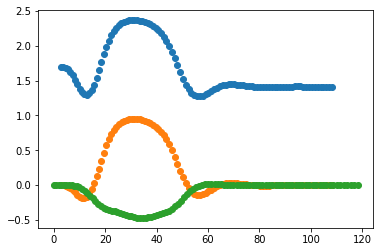

In [31]:
plt.plot(x_deb[0,:], x_deb[1,:],'o')
plt.plot(x2_deb[0,:], x2_deb[1,:],'o')
plt.plot(xamb_deb[0,:], xamb_deb[1,:],'o')

In [34]:
br3 = mpc.IterativeBestResponseMPC(amb_MPC, x2_MPC, x1_MPC)
br3.generate_optimization(N, min_dist, fd, T, x0_amb, x0_2, x0,  5)
br3.opti.set_initial(br3.x2_opt, x2r2)
br3.opti.set_initial(br3.xamb_opt, x1_current)
br3.opti.set_initial(br3.x_opt, xamb_current) # initialize it with the previous solution
br3.solve(u2r2, u1r1)
xambr3, uambr3, xamb_desr3, *_, = br3.get_solution()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     8430
Number of nonzeros in inequality constraint Jacobian.:     1816
Number of nonzeros in Lagrangian Hessian.............:     5129

Total number of variables............................:     2927
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2727
Total number of inequality constraints...............:     1008
        inequality constraints with only lower bounds:      202
   inequality constraints with lower and upper bounds:      806
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

KeyboardInterrupt: 

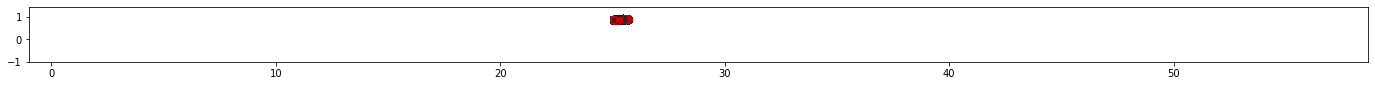

In [36]:
cplot.plot_cars(x2r2, xamb_current, xambr3, folder)

In [ ]:
x2_current, u2_current, x2_desired_current = x2r2, u2r2, x2_desr2

In [ ]:
CIRCLES = False
if CIRCLES:
    vid_fname = folder + subdir_name + 'circle2.mp4'
else:
    vid_fname = folder + subdir_name + 'car2_ghost.mp4'    
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
car1_v_cost = car1_s_cost
car2_v_cost = car2_s_cost
amb_v_cost = amb_s_cost

In [ ]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, k_lat1*car1_lat_cost, k_lon1*car1_lon_cost, k_phi1*car1_phi_cost, k_phid1*phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, k_phi2*car2_phi_cost, k_phid2*phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost,k_phiamb*amb_phi_cost, k_phidamb*phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

In [ ]:
for BR_iteration in range(20):
    opti2.set_value(x_opt2, sol.value(x_opt))
    opti2.set_value(u_opt2, sol.value(u_opt))

    opti2.set_value(xamb_opt2, sol.value(xamb_opt))
    opti2.set_value(uamb_opt2, sol.value(uamb_opt))

    opti2.set_initial(x2_opt2, sol.value(x2_opt))
    opti2.set_initial(u2_opt2, sol.value(u2_opt))
    sol2 = opti2.solve()

    opti3.set_value(x_opt3, sol2.value(x_opt2))
    opti3.set_value(u_opt3, sol2.value(u_opt2))

    opti3.set_value(x2_opt3, sol2.value(x2_opt2))
    opti3.set_value(u2_opt3, sol2.value(uamb_opt2))

    opti3.set_initial(xamb_opt3, sol2.value(xamb_opt2))
    opti3.set_initial(uamb_opt3, sol2.value(uamb_opt2))    
    sol3 = opti3.solve()
    
    
    opti.set_value(x2_opt, sol3.value(x2_opt3))
    opti.set_value(xamb_opt, sol3.value(xamb_opt3))
    opti.set_value(u2_opt, sol3.value(u2_opt3))
    opti.set_value(uamb_opt, sol3.value(uamb_opt3))

    opti.set_initial(x_opt, sol3.value(x_opt3))
    opti.set_initial(u_opt, sol3.value(u_opt3))    
    sol = opti.solve()
    
    x_warm = sol.value(x_opt)
    u_warm = sol.value(u_opt)
    x2_warm = sol.value(x2_opt)
    u2_warm = sol.value(u2_opt)
    xamb_warm = sol.value(xamb_opt)
    uamb_warm = sol.value(uamb_opt)

#     x_des = sol/

    for k in range(N+1):

        fig, ax = ego_car.get_frame(x_warm[:,k])
        fig, ax = ego_car.get_frame(x2_warm[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_warm[:,k], ax, amb=True)


#         ax.plot(x_des[0,:], x_des[1,:], '--')
#         ax.plot(x2_des[0,:], x2_des[1,:], '--')        

        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))

        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)         

    vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
    if os.path.exists(vid_fname):
        os.remove(vid_fname)
    cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
    os.system(cmd)
    print('Saving video to: {}'.format(vid_fname))

In [ ]:
for BR_iteration in range(20):        
    vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
    
    print('Saving video to: {}'.format(vid_fname))

## Best Response V2

In [ ]:
x1 = sol3.value(x_opt3)
x2 = sol3.value(x2_opt3)
xamb = sol3.value(xamb_opt3)
x_des = sol3.value(xamb_desired_3)

for k in range(N+1):

    fig, ax = ego_car.get_frame(x1[:,k])
    fig, ax = ego_car.get_frame(x2[:,k], ax)
    fig, ax = ego_car.get_frame(xamb[:,k], ax, amb=True)

    
    ax.plot(x_des[0,:], x_des[1,:], '--')
#     ax.plot(x2_des[0,:], x2_des[1,:], '--')        

    ax = plt.gca()
    window_width = 24
    window_height = window_width
    xmin, xmax = -1, -1+window_width
    ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)     
    
vid_fname = folder + 'caramb.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, 10*car1_lat_cost, 10*car1_lon_cost, car1_phi_cost, phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, car2_phi_cost, phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost, amb_phi_cost, phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

In [ ]:
sol.value(x_opt)[3:5, 10:20]

In [ ]:
dt

In [ ]:
plt.plot(opti.debug.value(x_opt)[4,:],'o',c='b')
plt.plot(opti.debug.value(x2_opt)[4,:],'o',c='g')
plt.plot(opti.debug.value(xamb_opt)[4,:],'o',c='r')
plt.ylabel("Velocity")
plt.show()

In [ ]:
plt.plot(opti.debug.value(u_opt)[1,:],'o',c='b')
plt.plot(opti.debug.value(u2_opt)[1,:],'o',c='g')
plt.plot(opti.debug.value(uamb_opt)[1,:],'o',c='r')
plt.ylabel("Acceleration $\delta V_u$")
plt.show()

In [ ]:
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.hlines(min_dist,0,50)
plt.ylabel('Intervehicle Distance')
plt.ylim([-.1, 2*min_dist])

In [ ]:
plt.plot([opti.debug.value(slack1) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='b')
plt.plot([opti.debug.value(slack2) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='r')
plt.plot([opti.debug.value(slack3) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='g')


# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.ylabel('slack')
# plt.ylim([.7,.71])

In [ ]:
if not PLOT_LIVE:
    for k in range(N+1):
        
        fig, ax = ego_car.get_frame(x_mpc[:,k])
        fig, ax = ego_car.get_frame(x2_mpc[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_mpc[:,k], ax, amb=True)
        
        ax.plot(x_des[0,:], x_des[1,:], '--')
        ax.plot(x2_des[0,:], x2_des[1,:], '--')        
        
        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))
        
        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)     